In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
import json
from tqdm.auto import tqdm
import random
import transformers


import os
import sys
sys.path.append('..')

from relations import estimate
from util import model_utils
from dsets.counterfact import CounterFactDataset
from util import nethook
from operator import itemgetter


In [3]:
MODEL_NAME = "EleutherAI/gpt-j-6B"  # gpt2-{medium,large,xl} or EleutherAI/gpt-j-6B
mt = model_utils.ModelAndTokenizer(MODEL_NAME, low_cpu_mem_usage=True, torch_dtype=torch.float32)

model = mt.model
tokenizer = mt.tokenizer
tokenizer.pad_token = tokenizer.eos_token

print(f"{MODEL_NAME} ==> device: {model.device}, memory: {model.get_memory_footprint()}")

EleutherAI/gpt-j-6B ==> device: cuda:0, memory: 24320971760


In [4]:
counterfact = CounterFactDataset("../data/")

Loaded dataset with 21919 elements


In [5]:
###################################################################################
final_layer_norm_name = "transformer.ln_f"
decoder_name = "lm_head"
###################################################################################

In [6]:
final_layer_norm = nethook.get_module(model, final_layer_norm_name)
decoder = nethook.get_module(model, decoder_name)

def get_vocab_representation(h, perform_layer_norm = True, return_top_k = 5):
    z = h.clone()
    if(perform_layer_norm == True):
        z = final_layer_norm(z)
    logits = decoder(z)
    token_ids = logits.topk(dim=-1, k=return_top_k).indices.squeeze().tolist()
    return [
        tokenizer.decode(t) for t in token_ids
    ]

In [7]:
cut_off = 50 # minimum number of correct predictions

###########################################################################
relation_dct = {
    'P17'   : {'relation': '{} is located in the country of', 'correct_predict': None, 'cached_JB': None},
    'P641'  : {'relation': '{} plays the sport of', 'correct_predict': None, 'cached_JB': None},
    'P103'  : {'relation': 'The mother tongue of {} is', 'correct_predict': None, 'cached_JB': None},
    'P176'  : {'relation': '{} is produced by', 'correct_predict': None, 'cached_JB': None},
    'P140'  : {'relation': 'The official religion of {} is', 'correct_predict': None, 'cached_JB': None},
    'P1303' : {'relation': '{} plays the instrument', 'correct_predict': None, 'cached_JB': None},
    'P190'  : {'relation': 'What is the twin city of {}? It is', 'correct_predict': None, 'cached_JB': None},
    'P740'  : {'relation': '{} was founded in', 'correct_predict': None, 'cached_JB': None},
    'P178'  : {'relation': '{} was developed by', 'correct_predict': None, 'cached_JB': None},
    'P495'  : {'relation': '{}, that originated in the country of', 'correct_predict': None, 'cached_JB': None},
    'P127'  : {'relation': '{} is owned by', 'correct_predict': None, 'cached_JB': None},
    'P413'  : {'relation': '{} plays in the position of', 'correct_predict': None, 'cached_JB': None},
    'P39'   : {'relation': '{}, who holds the position of', 'correct_predict': None, 'cached_JB': None},
    'P159'  : {'relation': 'The headquarter of {} is located in', 'correct_predict': None, 'cached_JB': None},
    'P20'   : {'relation': '{} died in the city of', 'correct_predict': None, 'cached_JB': None},
    'P136'  : {'relation': 'What does {} play? They play', 'correct_predict': None, 'cached_JB': None},
    'P106'  : {'relation': 'The profession of {} is', 'correct_predict': None, 'cached_JB': None},
    'P30'   : {'relation': '{} is located in the continent of', 'correct_predict': None, 'cached_JB': None},
    'P937'  : {'relation': '{} worked in the city of', 'correct_predict': None, 'cached_JB': None},
    'P449'  : {'relation': '{} was released on', 'correct_predict': None, 'cached_JB': None},
    'P27'   : {'relation': '{} is a citizen of', 'correct_predict': None, 'cached_JB': None},
    'P101'  : {'relation': '{} works in the field of', 'correct_predict': None, 'cached_JB': None},
    'P19'   : {'relation': '{} was born in', 'correct_predict': None, 'cached_JB': None},
    'P37'   : {'relation': 'In {}, an official language is', 'correct_predict': None, 'cached_JB': None},
    'P138'  : {'relation': '{}, named after', 'correct_predict': None, 'cached_JB': None},
    'P131'  : {'relation': '{} is located in', 'correct_predict': None, 'cached_JB': None},
    'P407'  : {'relation': '{} was written in', 'correct_predict': None, 'cached_JB': None},
    'P108'  : {'relation': '{}, who is employed by', 'correct_predict': None, 'cached_JB': None},
    'P36'   : {'relation': 'The capital of {} is', 'correct_predict': None, 'cached_JB': None},
}
###########################################################################

root_path = "gpt-j"

pop_track = []
for relation in relation_dct:
    path = f"{root_path}/{relation}"
    with open(f"{path}/correct_prediction_{relation}.json") as f:
        correct_predictions = json.load(f)
    if(len(correct_predictions) < cut_off):
    # if "performance" not in os.listdir(path):
        print("skipped ", relation)
        pop_track.append(relation)
    
for r in pop_track:
    relation_dct.pop(r)

skipped  P1303
skipped  P190
skipped  P740
skipped  P413
skipped  P39
skipped  P136
skipped  P449
skipped  P138
skipped  P131
skipped  P407
skipped  P108


## Calculating the Corner

In [8]:
from typing import Any, Sequence, TypeAlias, List
import matplotlib.pyplot as plt

Model: TypeAlias = transformers.GPT2LMHeadModel
Tokenizer: TypeAlias = transformers.PreTrainedTokenizerFast

def calculate_corner(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],

    learning_rate: float = 5e-2,
    weight_decay: float = 2e-2,
    num_steps: int = 100,
    target_logit_value: float = 50,

    plot_loss: bool = False
):
    target_tokenized = tokenizer(target_words, padding=True, return_tensors="pt").to(model.device)
    print(target_tokenized.input_ids.shape)

    tunable_weights = {}
    for n, p in model.named_parameters():
        if n.startswith(final_layer_norm_name) or n.startswith(decoder_name):
            tunable_weights[n] = p
            p.requires_grad = True
        else:
            p.requires_grad = False

    z = torch.FloatTensor(model.config.n_embd).uniform_(-1.001 , 1.001).to(model.dtype).to(model.device)
    print("initial representation: ", get_vocab_representation(z))
    z.requires_grad = True

    optimizer = torch.optim.Adam(
        [z],
        lr=learning_rate,
        weight_decay=weight_decay,
    )

    loss_track = []
    for iter in range(num_steps):
        logits = decoder(final_layer_norm(z))
        target_logits = torch.gather(logits, 0, target_tokenized.input_ids.reshape(len(target_words)))
        # print(target_logits)
        # loss = -target_logits.sum().square() #+ 1000 * entropy(target_logits) #+ logits.sum()

        optimal_logit_values = torch.zeros(target_logits.shape) + target_logit_value
        optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        # loss = (optimal_logit_values - target_logits).square().mean() + logits.square().mean()
        loss = (optimal_logit_values - target_logits).square().mean() + logits.mean()
        # print((optimal_logit_values - target_logits).square().mean().item(), logits.mean().item())

        # optimal_logit_values = torch.zeros(model.config.vocab_size) - 1
        # for t in target_tokenized.input_ids:
        #     optimal_logit_values[t[0]] = 10
        # optimal_logit_values = optimal_logit_values.to(model.dtype).to(model.device)
        # print(torch.gather(optimal_logit_values, 0, target_tokenized.input_ids.reshape(len(target_words))))
        # loss = (optimal_logit_values - logits).mean().square()
        
        loss_track.append(loss.item())
        # print(loss.item(), logits.mean().item(), target_logits.sum().item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        for t in tunable_weights:
            tunable_weights[t].grad.zero_()
    
    for t in tunable_weights:
        tunable_weights[t].requires_trad = False
    z.requires_grad = False
    print("final representation: ", get_vocab_representation(z))

    if(plot_loss):
        plt.rcdefaults()
        plt.plot(loss_track)
        plt.xticks(range(0, len(loss_track), 10))
        plt.xlabel("Iteration")
        plt.ylabel("loss")

    return z


def calculate_corner_average(
    model: Model, tokenizer: Tokenizer,
    target_words: List[str],

    learning_rate: float = 5e-2,
    weight_decay: float = 2e-2,
    num_steps: int = 100,
    target_logit_value: float = 50,

    plot_loss: bool = False,

    num_corners: int = 5 # calculate 5 corners and return the average of them
):  
    corners = [calculate_corner(
        model, tokenizer,
        target_words,
        learning_rate, weight_decay, num_steps, target_logit_value,
        plot_loss 
    ) for _ in range(num_corners)]

    corner = torch.stack(corners)
    return corner.mean(dim = 0)

# corner = calculate_corner_average(
#     model, tokenizer, objects,
#     # plot_loss= True,
# )

## Test on a relation

In [9]:
#################################################
relation_id = "P106"
precision_at = 3
#################################################

correctly predicted:  233
unique objects:  31 [' astronaut', ' biologist', ' programmer', ' curator', ' architect']
torch.Size([31, 1])
initial representation:  ['anon', ' Chop', 'GL', 'backs', 'Ont']
final representation:  [' scientist', ' writer', ' researcher', ' doctor', ' director']
torch.Size([31, 1])
initial representation:  [' Path', ' Classes', ' Delta', ' Survivors', ' spinal']
final representation:  [' scientist', ' writer', ' doctor', ' researcher', ' professor']
torch.Size([31, 1])
initial representation:  [' Ath', ' Rae', 'ws', ' Aw', 'aylor']
final representation:  [' scientist', ' writer', ' doctor', ' director', ' researcher']
torch.Size([31, 1])
initial representation:  ['new', 'Quant', 'MP', 'setup', 'Ob']
final representation:  [' scientist', ' writer', ' doctor', ' historian', ' director']
torch.Size([31, 1])
initial representation:  [' accounted', ' War', ' bag', ' coordinated', 'edIn']
final representation:  [' scientist', ' writer', ' doctor', ' historian', ' pr

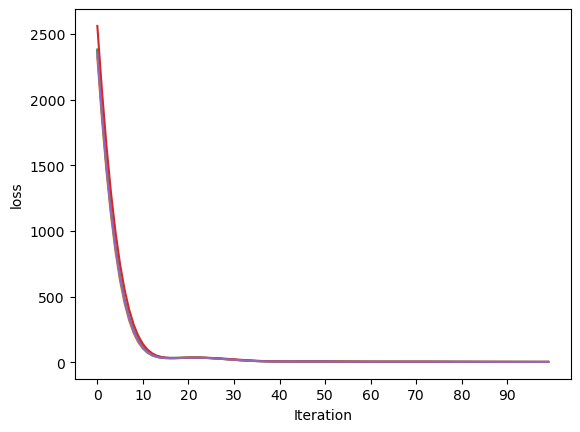

In [10]:
with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
    correct_predictions = json.load(f)
print("correctly predicted: ", len(correct_predictions))

objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
objects = [" "+ o['target_true']['str'] for o in objects]
objects = list(set(objects))
print("unique objects: ", len(objects), objects[0:5])

corner = calculate_corner_average(
    model, tokenizer, objects,
    plot_loss= True,
)

In [11]:
model.config.n_layer

28

In [12]:
relation = estimate.RelationOperator(
    model = model,
    tokenizer = tokenizer,
    relation = relation_dct[relation_id]['relation'],
    layer = 15,
    weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
    bias = corner
)

In [13]:
test_subjects = [
    "Hugh Jackman",
    "Michael Phelps",
    "Agatha Christie",
    "Barack Obama",
    "Sherlock Holmes",
    "Alan Turing",
    "Bill Gates",
    "Michelangelo",
    "Michael Jackson"
]

for sub in test_subjects:
    print(f"{sub} >> ", relation(sub, device= model.device))

Hugh Jackman >>  [' actor', ' director', ' writer', ' lawyer', ' filmmaker']
Michael Phelps >>  [' doctor', ' coach', ' scientist', ' director', ' surgeon']
Agatha Christie >>  [' novelist', ' writer', ' detective', ' author', ' historian']
Barack Obama >>  [' writer', ' doctor', ' scientist', ' lawyer', ' president']
Sherlock Holmes >>  [' detective', ' writer', ' novelist', ' doctor', ' actor']
Alan Turing >>  [' scientist', ' director', ' mathematician', ' doctor', ' physicist']
Bill Gates >>  [' engineer', ' lawyer', ' doctor', ' physician', ' economist']
Michelangelo >>  [' artist', ' writer', ' scholar', ' director', ' scientist']
Michael Jackson >>  [' singer', ' doctor', ' scientist', ' surgeon', ' artist']


In [14]:
# def P17__check_with_test_cases(relation_operator):

#     test_cases = [
#         ("The Great Wall", -1, "China"),
#         ("Niagara Falls", -2, "Canada"),
#         ("Valdemarsvik", -1, "Sweden"),
#         ("Kyoto University", -2, "Japan"),
#         ("Hattfjelldal", -1, "Norway"),
#         ("Ginza", -1, "Japan"),
#         ("Sydney Hospital", -2, "Australia"),
#         ("Mahalangur Himal", -1, "Nepal"),
#         ("Higashikagawa", -1, "Japan"),
#         ("Trento", -1, "Italy"),
#         ("Taj Mahal", -1, "India"),
#         ("Hagia Sophia", -1, "Turkey"),
#         ("Colosseum", -1, "Italy"),
#         ("Mount Everest", -1, "Nepal"),
#         ("Valencia", -1, "Spain"),
#         ("Lake Baikal", -1, "Russia"),
#         ("Merlion Park", -1, "Singapore"),
#         ("Cologne Cathedral", -1, "Germany"),
#         ("Buda Castle", -1, "Hungary")
#     ]

#     for subject, subject_token_index, target in test_cases:
#         objects = relation_operator(
#             subject,
#             subject_token_index=subject_token_index,
#             device=model.device,
#             return_top_k=5,
#         )
#         print(f"{subject}, target: {target}   ==>   predicted: {objects}")

# P17__check_with_test_cases(relation)

In [15]:
correct_predictions[0]

{'prompt': '{}, who works as',
 'relation_id': 'P106',
 'target_new': {'str': 'architect', 'id': 'Q42973'},
 'target_true': {'str': 'actor', 'id': 'Q33999'},
 'subject': 'Billy Roche'}

In [16]:
def get_most_frequent_objects(counterfact_requests):
    frequent_counter = {}
    for c in counterfact_requests:
        obj = c['target_true']['str']
        if(obj not in frequent_counter):
            frequent_counter[obj] = 0
        frequent_counter[obj] += 1

    lst = [(v, k) for k, v in frequent_counter.items()]
    lst = sorted(lst, reverse=True)
    most_frequent_predictions = [n for c, n in lst][: precision_at]

    return most_frequent_predictions

most_frequent_predictions = get_most_frequent_objects(correct_predictions)
most_frequent_predictions

['actor', 'architect', 'astronomer']

In [17]:
def calculate_accuracy(relation, counterfact_requests):

    most_frequent_predictions = get_most_frequent_objects(counterfact_requests)
    relation_correct = 0
    frequency_correct = 0

    for c in tqdm(counterfact_requests):
        sub = c['subject']
        target = c['target_true']['str']
        relation_prediction = False
        predictions = relation(sub, device=model.device)
        for o in predictions[0:precision_at]:
            _o = o.strip()
            if(len(_o) == 0):
                continue
            if target.startswith(_o):
                relation_prediction = True
                break
        frequency_prediction = target == most_frequent_predictions[0]

        relation_correct += relation_prediction
        frequency_correct += frequency_prediction

    return relation_correct/len(counterfact_requests), frequency_correct/len(counterfact_requests)

calculate_accuracy(relation, correct_predictions)

  0%|          | 0/233 [00:00<?, ?it/s]

(0.13304721030042918, 0.9141630901287554)

## Check on all the relations

In [18]:
accuracy_tracker = {}

for relation_id in relation_dct:
    print("######################################################################################################")
    print(relation_id, ":", relation_dct[relation_id]["relation"])
    print("######################################################################################################")

    with open(f"{root_path}/{relation_id}/correct_prediction_{relation_id}.json") as f:
        correct_predictions = json.load(f)
    print(f"correctly predicted by {MODEL_NAME}: ", len(correct_predictions))
    if(len(correct_predictions) < cut_off):
        print("SKIPPING >>> len(correct_predictions): ", len(correct_predictions))
        continue

    objects = [c['requested_rewrite'] for c in counterfact if c["requested_rewrite"]['relation_id'] == relation_id]
    objects = [" "+ o['target_true']['str'] for o in objects]
    objects = list(set(objects))
    print("unique objects: ", len(objects), objects[0:min(5, len(objects))])

    # corner = calculate_corner_average(model, tokenizer, objects)
    corner = calculate_corner(model, tokenizer, objects)

    accuracy_tracker[relation_id] = {
        'corner_acc': {},
        'freq_acc'  : None,
        'out_of'    : len(correct_predictions)
    }
    for layer in range(7, 21):
        print(f"----------------- LAYER {layer} -----------------")
        relation = estimate.RelationOperator(
            model = model,
            tokenizer = tokenizer,
            relation = relation_dct[relation_id]['relation'],
            layer = layer,
            weight = torch.eye(model.config.n_embd).to(model.dtype).to(model.device),
            bias = corner
        )

        relation_acc, freq_acc = calculate_accuracy(relation, correct_predictions)
        print(f"layer {layer} >> corner accurace: {relation_acc}, freq_acc: {freq_acc} || out of {len(correct_predictions)}")
        accuracy_tracker[relation_id]["corner_acc"][f"layer_{layer}"] = relation_acc
        if(accuracy_tracker[relation_id]["freq_acc"] is None):
            accuracy_tracker[relation_id]["freq_acc"] = freq_acc
        # accuracy_tracker[relation_id] = {"relation_acc": relation_acc, "freq_acc": freq_acc, "out_of": len(correct_predictions)}
    # print(accuracy_tracker[relation_id])
    print("######################################################################################################")
    print()


######################################################################################################
P17 : {} is located in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  404
unique objects:  95 [' Ghana', ' Afghanistan', ' Madagascar', ' Bahamas', ' Bolivia']
torch.Size([95, 1])
initial representation:  ['adel', 'ICT', ' phenomenon', ' courtesy', ' yours']
final representation:  [' Ukraine', ' Nigeria', ' Bangladesh', ' Finland', ' Malaysia']
----------------- LAYER 7 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.2599009900990099, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 8 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.30445544554455445, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 9 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.28465346534653463, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 10 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.3589108910891089, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 11 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.3613861386138614, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 12 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.8292079207920792, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 13 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8316831683168316, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 14 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8712871287128713, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 15 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8613861386138614, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 16 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9331683168316832, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 17 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9282178217821783, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 18 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9257425742574258, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 19 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9356435643564357, freq_acc: 0.09653465346534654 || out of 404
----------------- LAYER 20 -----------------


  0%|          | 0/404 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9306930693069307, freq_acc: 0.09653465346534654 || out of 404
######################################################################################################

######################################################################################################
P641 : {} plays the sport of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  195
unique objects:  5 [' basketball', ' football', ' baseball', ' soccer', ' hockey']
torch.Size([5, 1])
initial representation:  [' Unt', ' Res', ' hint', ' state', ' SI']
final representation:  [' soccer', ' basketball', ' hockey', ' baseball', ' football']
----------------- LAYER 7 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.8358974358974359, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 8 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.8666666666666667, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 9 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8871794871794871, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 10 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.8974358974358975, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 11 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.9333333333333333, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 12 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 13 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 14 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9794871794871794, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 15 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 16 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 17 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 18 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9846153846153847, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 19 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 19 >> corner accurace: 1.0, freq_acc: 0.26666666666666666 || out of 195
----------------- LAYER 20 -----------------


  0%|          | 0/195 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9948717948717949, freq_acc: 0.26666666666666666 || out of 195
######################################################################################################

######################################################################################################
P103 : The mother tongue of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  317
unique objects:  30 [' Chinese', ' Welsh', ' Georgian', ' Persian', ' Russian']
torch.Size([30, 1])
initial representation:  [' Architecture', ' b', 'STAT', 'sd', 'Form']
final representation:  [' Romanian', ' Finnish', ' Spanish', ' Danish', ' Turkish']
----------------- LAYER 7 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.750788643533123, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 8 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.7854889589905363, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 9 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8138801261829653, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 10 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.8359621451104101, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 11 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.8454258675078864, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 12 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9621451104100947, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 13 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9684542586750788, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 14 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9779179810725552, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 15 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9810725552050473, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 16 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9905362776025236, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 17 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9905362776025236, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 18 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9936908517350158, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 19 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9968454258675079, freq_acc: 0.6340694006309149 || out of 317
----------------- LAYER 20 -----------------


  0%|          | 0/317 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9936908517350158, freq_acc: 0.6340694006309149 || out of 317
######################################################################################################

######################################################################################################
P176 : {} is produced by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  543
unique objects:  37 [' Airbus', ' McLaren', ' BMW', ' Jeep', ' Porsche']
torch.Size([37, 1])
initial representation:  ['lang', 'achi', 'way', 'ur', 'REL']
final representation:  [' Ford', ' Mercedes', ' Toyota', ' Boeing', ' Chrysler']
----------------- LAYER 7 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.3388581952117864, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 8 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.3370165745856354, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 9 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.30570902394106814, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 10 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.4088397790055249, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 11 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.3848987108655617, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 12 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.8397790055248618, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 13 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8029465930018416, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 14 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8195211786372008, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 15 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8047882136279927, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 16 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9244935543278084, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 17 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9502762430939227, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 18 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9502762430939227, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 19 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9723756906077348, freq_acc: 0.13627992633517497 || out of 543
----------------- LAYER 20 -----------------


  0%|          | 0/543 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9686924493554327, freq_acc: 0.13627992633517497 || out of 543
######################################################################################################

######################################################################################################
P140 : The official religion of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  182
unique objects:  9 [' Islam', ' Zen', ' Muslim', ' Christianity', ' Judaism']
torch.Size([9, 1])
initial representation:  ['ju', ' compat', 'ji', ' \u200b', 'jun']
final representation:  [' Christianity', ' Scientology', ' Muslim', ' Catholicism', ' Catholic']
----------------- LAYER 7 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.7747252747252747, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 8 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.6428571428571429, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 9 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.6923076923076923, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 10 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.6648351648351648, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 11 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.6703296703296703, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 12 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9340659340659341, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 13 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8901098901098901, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 14 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8571428571428571, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 15 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9010989010989011, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 16 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9560439560439561, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 17 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9505494505494505, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 18 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 19 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
----------------- LAYER 20 -----------------


  0%|          | 0/182 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.967032967032967, freq_acc: 0.8186813186813187 || out of 182
######################################################################################################

######################################################################################################
P178 : {} was developed by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  400
unique objects:  19 [' Airbus', ' Adobe', ' Microsoft', ' Atari', ' Square']
torch.Size([19, 1])
initial representation:  [' Flag', ' annot', 'Top', ' Cyber', ' curs']
final representation:  [' Sony', ' Nintendo', ' IBM', ' Airbus', ' Samsung']
----------------- LAYER 7 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.655, freq_acc: 0.3425 || out of 400
----------------- LAYER 8 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.66, freq_acc: 0.3425 || out of 400
----------------- LAYER 9 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.59, freq_acc: 0.3425 || out of 400
----------------- LAYER 10 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.7175, freq_acc: 0.3425 || out of 400
----------------- LAYER 11 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.6525, freq_acc: 0.3425 || out of 400
----------------- LAYER 12 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9275, freq_acc: 0.3425 || out of 400
----------------- LAYER 13 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
----------------- LAYER 14 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.905, freq_acc: 0.3425 || out of 400
----------------- LAYER 15 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.89, freq_acc: 0.3425 || out of 400
----------------- LAYER 16 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9275, freq_acc: 0.3425 || out of 400
----------------- LAYER 17 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9175, freq_acc: 0.3425 || out of 400
----------------- LAYER 18 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
----------------- LAYER 19 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.905, freq_acc: 0.3425 || out of 400
----------------- LAYER 20 -----------------


  0%|          | 0/400 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9075, freq_acc: 0.3425 || out of 400
######################################################################################################

######################################################################################################
P495 : {}, that originated in the country of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  160
unique objects:  67 [' Turkey', ' Netherlands', ' Argentina', ' Ireland', ' Haiti']
torch.Size([67, 1])
initial representation:  ['definition', 'concept', 'target', ' concept', ' carve']
final representation:  [' Ireland', ' Nigeria', ' Thailand', ' Belgium', ' Lebanon']
----------------- LAYER 7 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.3375, freq_acc: 0.33125 || out of 160
----------------- LAYER 8 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.375, freq_acc: 0.33125 || out of 160
----------------- LAYER 9 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.375, freq_acc: 0.33125 || out of 160
----------------- LAYER 10 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.46875, freq_acc: 0.33125 || out of 160
----------------- LAYER 11 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.475, freq_acc: 0.33125 || out of 160
----------------- LAYER 12 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.85625, freq_acc: 0.33125 || out of 160
----------------- LAYER 13 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.875, freq_acc: 0.33125 || out of 160
----------------- LAYER 14 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
----------------- LAYER 15 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.85, freq_acc: 0.33125 || out of 160
----------------- LAYER 16 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.925, freq_acc: 0.33125 || out of 160
----------------- LAYER 17 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9125, freq_acc: 0.33125 || out of 160
----------------- LAYER 18 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
----------------- LAYER 19 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.91875, freq_acc: 0.33125 || out of 160
----------------- LAYER 20 -----------------


  0%|          | 0/160 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.89375, freq_acc: 0.33125 || out of 160
######################################################################################################

######################################################################################################
P127 : {} is owned by
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  105
unique objects:  109 [' Rome', ' Louisiana', ' Naples', ' Nike', ' Leonardo']
torch.Size([109, 1])
initial representation:  [' participating', 'authors', ' enroll', ' administering', 'ECH']
final representation:  [' Florida', ' Moscow', ' Amsterdam', ' Arizona', ' Japan']
----------------- LAYER 7 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.05714285714285714, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 8 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.05714285714285714, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 9 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.0761904761904762, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 10 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.10476190476190476, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 11 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.06666666666666667, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 12 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4095238095238095, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 13 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.38095238095238093, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 14 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.38095238095238093, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 15 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.3047619047619048, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 16 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.47619047619047616, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 17 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5047619047619047, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 18 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.5142857142857142, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 19 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5523809523809524, freq_acc: 0.3904761904761905 || out of 105
----------------- LAYER 20 -----------------


  0%|          | 0/105 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5428571428571428, freq_acc: 0.3904761904761905 || out of 105
######################################################################################################

######################################################################################################
P159 : The headquarter of {} is located in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  157
unique objects:  178 [' Southampton', ' Rome', ' Stockholm', ' Copenhagen', ' Brunswick']
torch.Size([178, 1])
initial representation:  [' equival', ' vi', ' alternative', ' \u200b', ' equ']
final representation:  [' Washington', ' Birmingham', ' Lebanon', ' Berlin', ' Cairo']
----------------- LAYER 7 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.08280254777070063, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 8 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.09554140127388536, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 9 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.07643312101910828, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 10 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1592356687898089, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 11 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.14012738853503184, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 12 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4585987261146497, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 13 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.43312101910828027, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 14 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.46496815286624205, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 15 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.39490445859872614, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 16 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.5159235668789809, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 17 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5477707006369427, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 18 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.535031847133758, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 19 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5222929936305732, freq_acc: 0.07006369426751592 || out of 157
----------------- LAYER 20 -----------------


  0%|          | 0/157 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5477707006369427, freq_acc: 0.07006369426751592 || out of 157
######################################################################################################

######################################################################################################
P20 : {} died in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  144
unique objects:  169 [' Southampton', ' Rome', ' Stockholm', ' Brighton', ' Copenhagen']
torch.Size([169, 1])
initial representation:  [' cock', 'ister', 'ide', ' off', 'rew']
final representation:  [' Washington', ' Lebanon', ' Cairo', ' Moscow', ' Athens']
----------------- LAYER 7 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.2708333333333333, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 8 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.2986111111111111, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 9 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.2986111111111111, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 10 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.3472222222222222, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 11 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.375, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 12 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.6041666666666666, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 13 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.5763888888888888, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 14 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.5694444444444444, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 15 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.5555555555555556, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 16 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.5902777777777778, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 17 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.6180555555555556, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 18 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.6041666666666666, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 19 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5763888888888888, freq_acc: 0.2569444444444444 || out of 144
----------------- LAYER 20 -----------------


  0%|          | 0/144 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.5486111111111112, freq_acc: 0.2569444444444444 || out of 144
######################################################################################################

######################################################################################################
P106 : The profession of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  233
unique objects:  31 [' astronaut', ' biologist', ' programmer', ' curator', ' architect']
torch.Size([31, 1])
initial representation:  [' Attend', ' attendance', 'current', 'crit', ' ISS']
final representation:  [' scientist', ' writer', ' doctor', ' professor', ' historian']
----------------- LAYER 7 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.0815450643776824, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 8 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.060085836909871244, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 9 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.13304721030042918, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 10 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.13733905579399142, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 11 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.11158798283261803, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 12 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.1630901287553648, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 13 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.13733905579399142, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 14 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.1459227467811159, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 15 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.12017167381974249, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 16 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.15450643776824036, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 17 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.19313304721030042, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 18 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.17167381974248927, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 19 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.1459227467811159, freq_acc: 0.9141630901287554 || out of 233
----------------- LAYER 20 -----------------


  0%|          | 0/233 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.15450643776824036, freq_acc: 0.9141630901287554 || out of 233
######################################################################################################

######################################################################################################
P30 : {} is located in the continent of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  456
unique objects:  5 [' Antarctica', ' Asia', ' Africa', ' Europe', ' Americas']
torch.Size([5, 1])
initial representation:  [' press', ' solutions', ' surrounds', ' oppos', 'EMS']
final representation:  [' Asia', ' Africa', ' Antarctica', ' Europe', ' Americas']
----------------- LAYER 7 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.7872807017543859, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 8 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.8114035087719298, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 9 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.8245614035087719, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 10 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.868421052631579, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 11 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.8706140350877193, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 12 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 13 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9671052631578947, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 14 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9714912280701754, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 15 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 16 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9627192982456141, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 17 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9385964912280702, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 18 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9385964912280702, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 19 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9035087719298246, freq_acc: 0.5592105263157895 || out of 456
----------------- LAYER 20 -----------------


  0%|          | 0/456 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8771929824561403, freq_acc: 0.5592105263157895 || out of 456
######################################################################################################

######################################################################################################
P937 : {} worked in the city of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  328
unique objects:  90 [' Rome', ' Stockholm', ' Copenhagen', ' Scotland', ' Sheffield']
torch.Size([90, 1])
initial representation:  ['tur', ' Tur', ' Heat', ' Manual', ' passion']
final representation:  [' Seattle', ' Birmingham', ' Hamburg', ' Denver', ' Minneapolis']
----------------- LAYER 7 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.27134146341463417, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 8 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.3353658536585366, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 9 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.29878048780487804, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 10 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.38414634146341464, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 11 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.4420731707317073, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 12 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.6615853658536586, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 13 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.6859756097560976, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 14 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.7195121951219512, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 15 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.7530487804878049, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 16 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.801829268292683, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 17 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.7926829268292683, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 18 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.7835365853658537, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 19 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.7713414634146342, freq_acc: 0.3231707317073171 || out of 328
----------------- LAYER 20 -----------------


  0%|          | 0/328 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.75, freq_acc: 0.3231707317073171 || out of 328
######################################################################################################

######################################################################################################
P27 : {} is a citizen of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  305
unique objects:  97 [' Scotland', ' Ghana', ' Niger', ' Afghanistan', ' England']
torch.Size([97, 1])
initial representation:  ['imes', 'tv', 'v', ' FM', ' modern']
final representation:  [' Nigeria', ' Africa', ' Finland', ' Cyprus', ' Bangladesh']
----------------- LAYER 7 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.4098360655737705, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 8 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.4819672131147541, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 9 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.4786885245901639, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 10 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.5639344262295082, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 11 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.521311475409836, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 12 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.921311475409836, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 13 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.9147540983606557, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 14 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.9475409836065574, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 15 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.9278688524590164, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 16 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.9770491803278688, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 17 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.9836065573770492, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 18 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.9836065573770492, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 19 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.9770491803278688, freq_acc: 0.1737704918032787 || out of 305
----------------- LAYER 20 -----------------


  0%|          | 0/305 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.9672131147540983, freq_acc: 0.1737704918032787 || out of 305
######################################################################################################

######################################################################################################
P101 : {} works in the field of
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  82
unique objects:  83 [' jazz', ' psychology', ' art', ' Afghanistan', ' espionage']
torch.Size([83, 1])
initial representation:  ['.-', 'lli', ' refere', 'llan', 'XP']
final representation:  [' music', ' social', ' medical', ' human', ' military']
----------------- LAYER 7 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.12195121951219512, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 8 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.10975609756097561, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 9 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.0975609756097561, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 10 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.17073170731707318, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 11 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.18292682926829268, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 12 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.25609756097560976, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 13 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.23170731707317074, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 14 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.2682926829268293, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 15 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 16 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 17 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.3170731707317073, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 18 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.35365853658536583, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 19 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.34146341463414637, freq_acc: 0.12195121951219512 || out of 82
----------------- LAYER 20 -----------------


  0%|          | 0/82 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.35365853658536583, freq_acc: 0.12195121951219512 || out of 82
######################################################################################################

######################################################################################################
P19 : {} was born in
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  128
unique objects:  229 [' Southampton', ' Rome', ' Copenhagen', ' Stockholm', ' Brunswick']
torch.Size([229, 1])
initial representation:  ['Op', 'Torrent', 'Category', 'Se', 'Expl']
final representation:  [' Richmond', ' South', ' San', ' St', ' West']
----------------- LAYER 7 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.1171875, freq_acc: 0.125 || out of 128
----------------- LAYER 8 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.1328125, freq_acc: 0.125 || out of 128
----------------- LAYER 9 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.1171875, freq_acc: 0.125 || out of 128
----------------- LAYER 10 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1328125, freq_acc: 0.125 || out of 128
----------------- LAYER 11 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.1484375, freq_acc: 0.125 || out of 128
----------------- LAYER 12 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.4375, freq_acc: 0.125 || out of 128
----------------- LAYER 13 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.453125, freq_acc: 0.125 || out of 128
----------------- LAYER 14 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.5, freq_acc: 0.125 || out of 128
----------------- LAYER 15 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.4765625, freq_acc: 0.125 || out of 128
----------------- LAYER 16 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.546875, freq_acc: 0.125 || out of 128
----------------- LAYER 17 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.5234375, freq_acc: 0.125 || out of 128
----------------- LAYER 18 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.5390625, freq_acc: 0.125 || out of 128
----------------- LAYER 19 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.5234375, freq_acc: 0.125 || out of 128
----------------- LAYER 20 -----------------


  0%|          | 0/128 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.453125, freq_acc: 0.125 || out of 128
######################################################################################################

######################################################################################################
P37 : In {}, an official language is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  156
unique objects:  44 [' Persian', ' Chinese', ' Welsh', ' Georgian', ' Somali']
torch.Size([44, 1])
initial representation:  ['-----------', 'iol', 'etime', ' Rounds', '*/']
final representation:  [' Scottish', ' Spanish', ' Finnish', ' Thai', ' Irish']
----------------- LAYER 7 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.36538461538461536, freq_acc: 0.25 || out of 156
----------------- LAYER 8 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.33974358974358976, freq_acc: 0.25 || out of 156
----------------- LAYER 9 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.3782051282051282, freq_acc: 0.25 || out of 156
----------------- LAYER 10 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.5, freq_acc: 0.25 || out of 156
----------------- LAYER 11 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.5, freq_acc: 0.25 || out of 156
----------------- LAYER 12 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.7756410256410257, freq_acc: 0.25 || out of 156
----------------- LAYER 13 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.8269230769230769, freq_acc: 0.25 || out of 156
----------------- LAYER 14 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.8205128205128205, freq_acc: 0.25 || out of 156
----------------- LAYER 15 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.8461538461538461, freq_acc: 0.25 || out of 156
----------------- LAYER 16 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.8717948717948718, freq_acc: 0.25 || out of 156
----------------- LAYER 17 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.8717948717948718, freq_acc: 0.25 || out of 156
----------------- LAYER 18 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.8910256410256411, freq_acc: 0.25 || out of 156
----------------- LAYER 19 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.8910256410256411, freq_acc: 0.25 || out of 156
----------------- LAYER 20 -----------------


  0%|          | 0/156 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8205128205128205, freq_acc: 0.25 || out of 156
######################################################################################################

######################################################################################################
P36 : The capital of {} is
######################################################################################################
correctly predicted by EleutherAI/gpt-j-6B:  68
unique objects:  62 [' Santiago', ' Tokyo', ' Copenhagen', ' Rome', ' Stockholm']
torch.Size([62, 1])
initial representation:  [' hear', ' tended', ' dream', ' necessarily', ' tend']
final representation:  [' Istanbul', ' Moscow', ' Alexandria', ' Hamburg', ' Vienna']
----------------- LAYER 7 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 7 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 8 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 8 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 9 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 9 >> corner accurace: 0.08823529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 10 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 10 >> corner accurace: 0.1323529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 11 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 11 >> corner accurace: 0.1323529411764706, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 12 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 12 >> corner accurace: 0.7205882352941176, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 13 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 13 >> corner accurace: 0.7058823529411765, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 14 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 14 >> corner accurace: 0.7205882352941176, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 15 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 15 >> corner accurace: 0.6029411764705882, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 16 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 16 >> corner accurace: 0.8970588235294118, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 17 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 17 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 18 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 18 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 19 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 19 >> corner accurace: 0.8529411764705882, freq_acc: 0.058823529411764705 || out of 68
----------------- LAYER 20 -----------------


  0%|          | 0/68 [00:00<?, ?it/s]

layer 20 >> corner accurace: 0.8676470588235294, freq_acc: 0.058823529411764705 || out of 68
######################################################################################################



In [27]:
with open("corner_accuracies__different_layers.json", "w") as f:
    json.dump(accuracy_tracker, f)

## Plotting

In [31]:
def get_info_for_plotting(accuracy_tracker, layer = 15):
    lst = []
    for r in accuracy_tracker:
        lst.append({
            "relation": r,
            "corner_acc": accuracy_tracker[r]["corner_acc"][f"layer_{layer}"],
            "freq_acc": accuracy_tracker[r]["freq_acc"],
            "out_of"  : accuracy_tracker[r]["out_of"]
        }) 
    lst.sort(key = itemgetter("corner_acc"))
    corner_accuracies = []
    freq_accuracies = []
    relations = []
    for r in lst:
        relations.append(f"{relation_dct[r['relation']]['relation']} <> {r['relation']} [{r['out_of']}]")
        corner_accuracies.append(r["corner_acc"])
        freq_accuracies.append(r["freq_acc"])

    return relations, corner_accuracies, freq_accuracies

In [49]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (20,17)
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 14
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=BIGGER_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=BIGGER_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title


def plot_performance_comparison(layer, relations, relation_accuracies, freq_accuracies, save_path = None):
    y = np.arange(len(relations))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.barh(y + width/2, relation_accuracies, width, label='Relation')
    rects2 = ax.barh(y - width/2, freq_accuracies, width, label='Most Frequent')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores')
    ax.set_title(f'Layer {layer} ---- Precision @ 3 with bias = corner and J = Identity')
    ax.set_yticks(y, relations)
    ax.legend(loc="upper center", ncol=2)

    ax.bar_label(rects1, padding=3)
    ax.bar_label(rects2, padding=3)

    fig.tight_layout()

    if(save_path is not None):
        os.makedirs(save_path, exist_ok = True)
        plt.savefig(f"{save_path}/corner__layer_{layer}.png")

    return fig

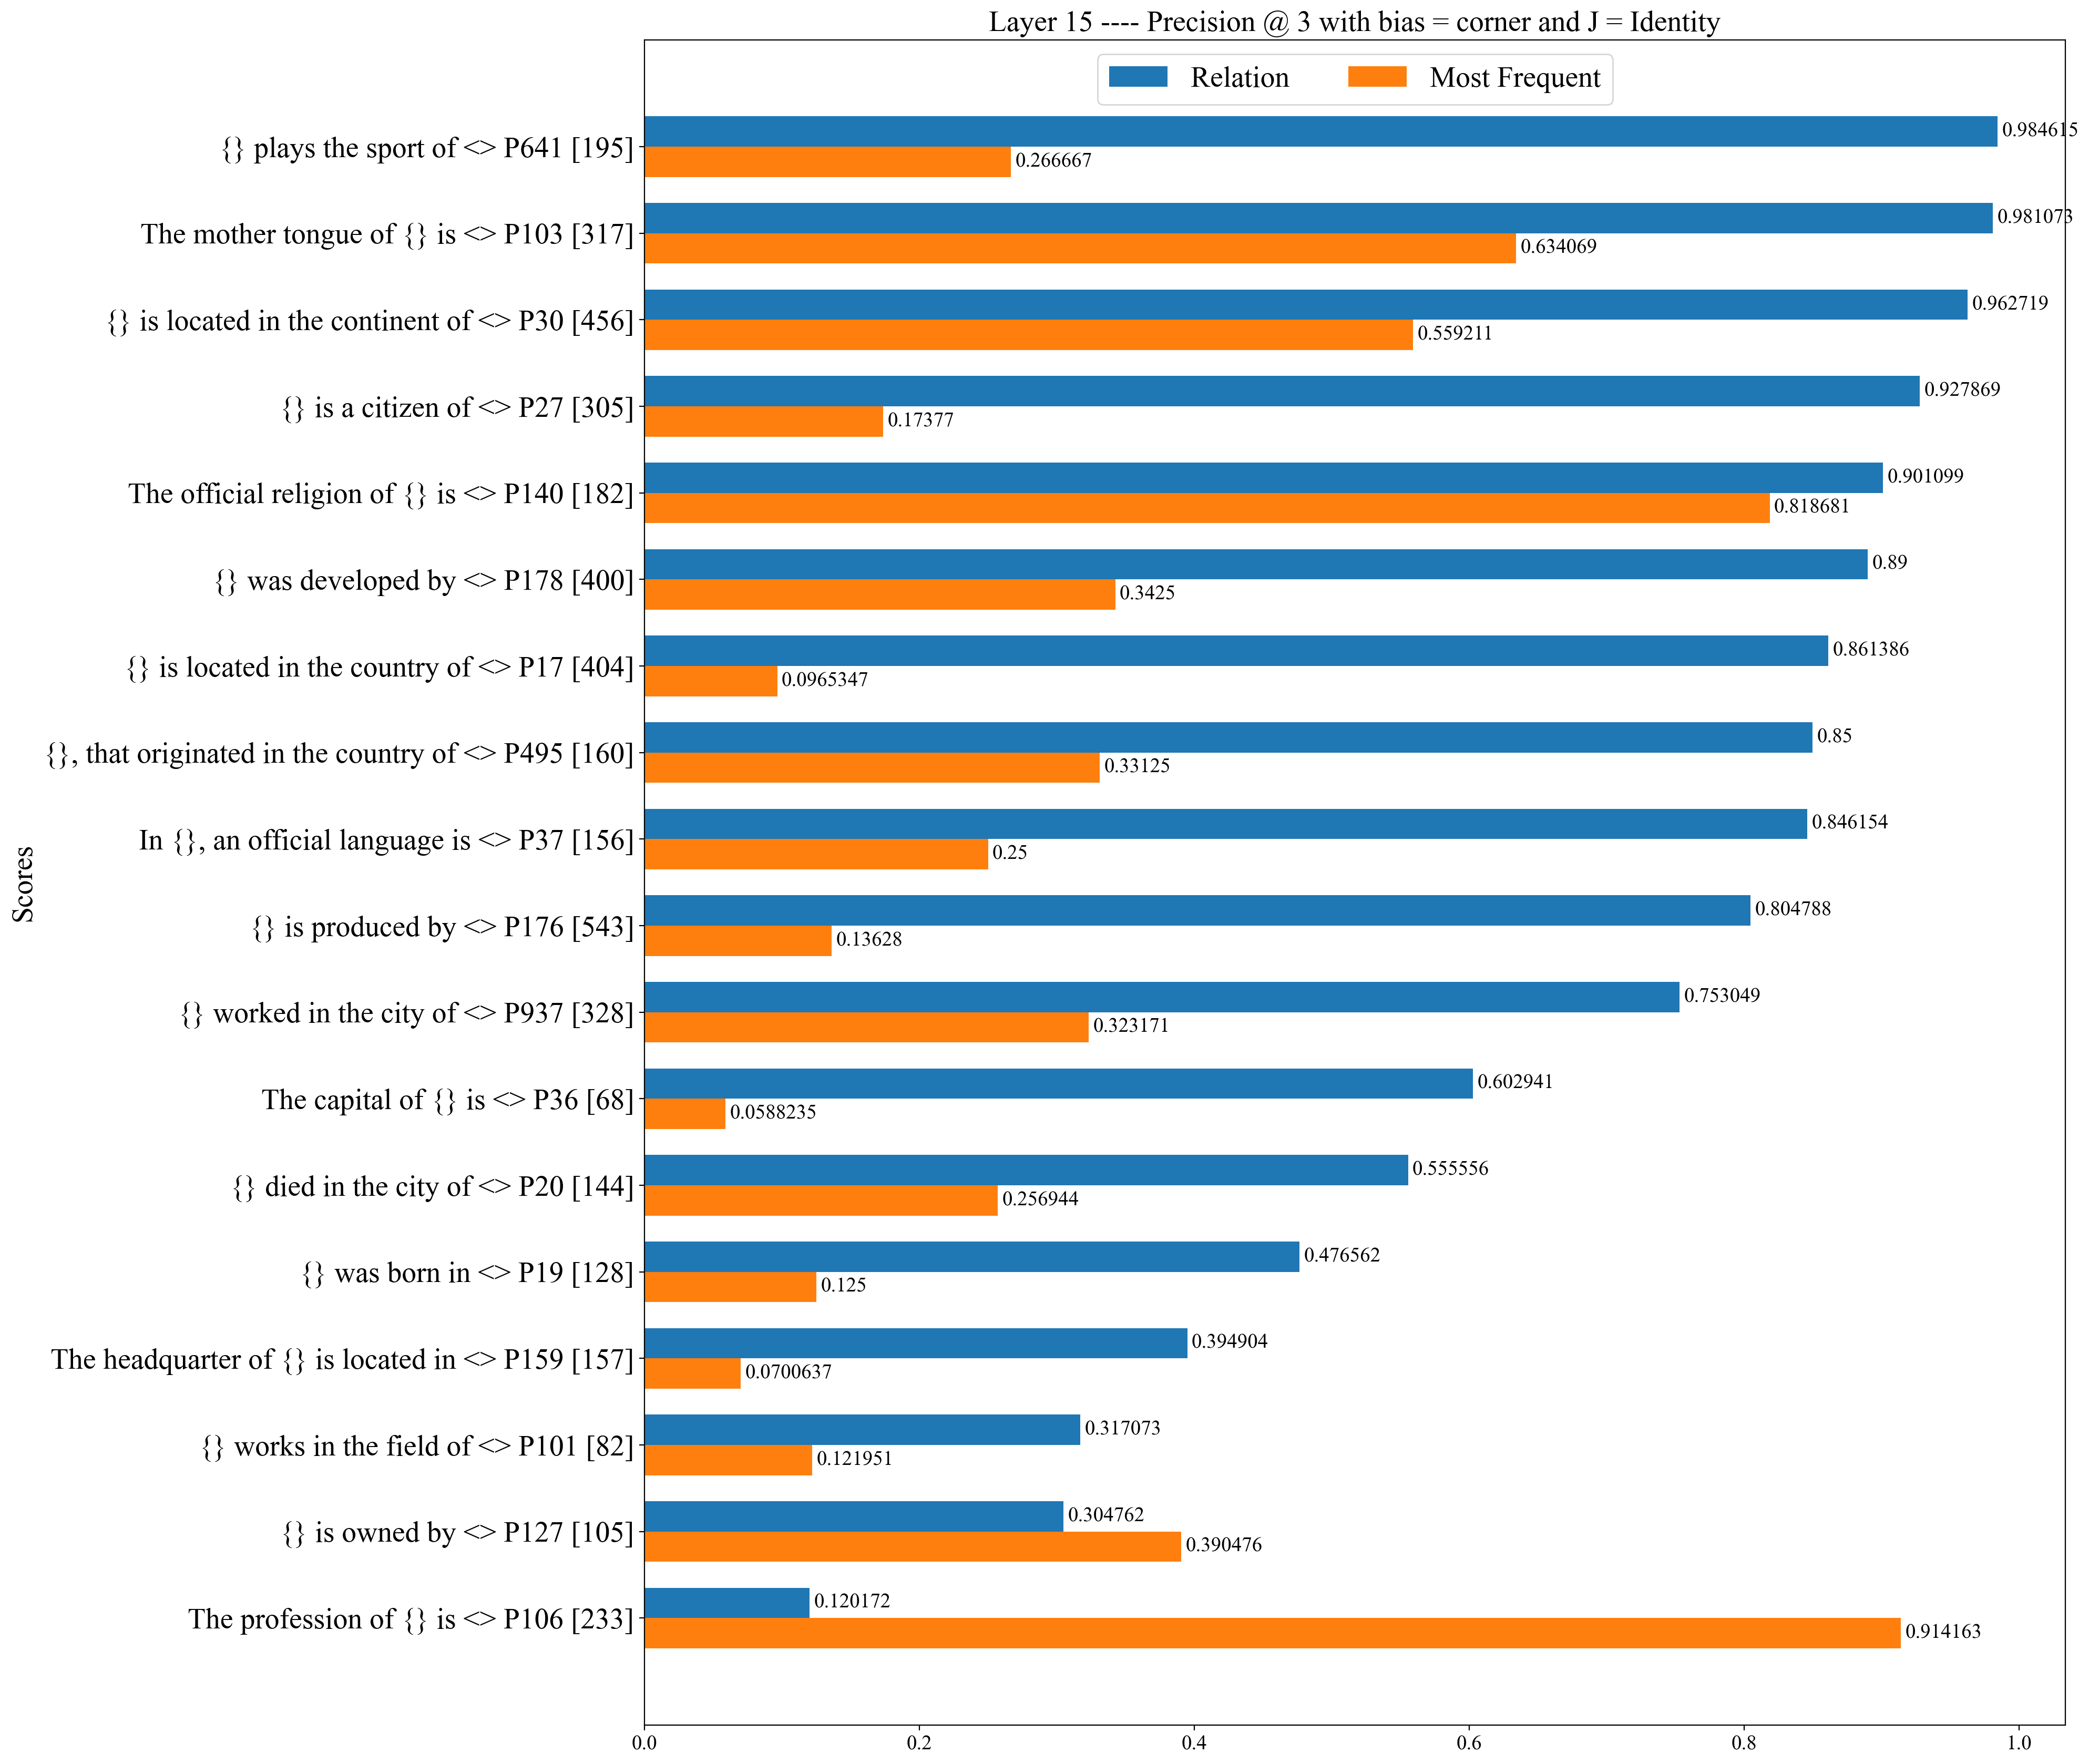

In [52]:
layer = 15
relations, corner_accuracies, freq_accuracies = get_info_for_plotting(accuracy_tracker, layer = layer)
fig = plot_performance_comparison(layer, relations, corner_accuracies, freq_accuracies, save_path="Performance/Layerwise")

# for layer in range(7, 21):
#     relations, corner_accuracies, freq_accuracies = get_info_for_plotting(accuracy_tracker, layer = layer)
#     fig = plot_performance_comparison(layer, relations, corner_accuracies, freq_accuracies, save_path="Performance/Layerwise")

In [55]:
relation_layerwise = {}
layers = list(range(7, 21))
for relation in accuracy_tracker:
    relation_layerwise[relation] = []
    for layer in layers:
        relation_layerwise[relation].append(accuracy_tracker[relation]["corner_acc"][f"layer_{layer}"])

{'P17': [0.2599009900990099,
  0.30445544554455445,
  0.28465346534653463,
  0.3589108910891089,
  0.3613861386138614,
  0.8292079207920792,
  0.8316831683168316,
  0.8712871287128713,
  0.8613861386138614,
  0.9331683168316832,
  0.9282178217821783,
  0.9257425742574258,
  0.9356435643564357,
  0.9306930693069307],
 'P641': [0.8358974358974359,
  0.8666666666666667,
  0.8871794871794871,
  0.8974358974358975,
  0.9333333333333333,
  0.9794871794871794,
  0.9794871794871794,
  0.9794871794871794,
  0.9846153846153847,
  0.9846153846153847,
  0.9846153846153847,
  0.9846153846153847,
  1.0,
  0.9948717948717949],
 'P103': [0.750788643533123,
  0.7854889589905363,
  0.8138801261829653,
  0.8359621451104101,
  0.8454258675078864,
  0.9621451104100947,
  0.9684542586750788,
  0.9779179810725552,
  0.9810725552050473,
  0.9905362776025236,
  0.9905362776025236,
  0.9936908517350158,
  0.9968454258675079,
  0.9936908517350158],
 'P176': [0.3388581952117864,
  0.3370165745856354,
  0.30570902

## Get Jacobians